# Prediction of an employee's salary according to his characteristics
### Examination project for the Data Intensive Application Programming course - 2022/2023
Babboni Luca \
luca.babboni2@studio.unibo.it \
Mat: 0000971126


## Import of main libraries

We import the commonly used libraries that we will need when analysing the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#to avoid warnings 
from warnings import filterwarnings
filterwarnings('ignore')

## Importing data
The dataset used for this project is called [Salary_Data](https://www.kaggle.com/datasets/mohithsairamreddy/salary-data) and is available on [Kaggle](https://www.kaggle.com).


In [3]:
#import os to be able to read files
import os.path as os
import kaggle

In [4]:
#if the file is not present, download it from kaggle
#if the kaggle extension is not installed and the .csv file is present you can avoid to execute this cell
if not os.exists("Salary_Data.csv"):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        'mohithsairamreddy/salary-data', path='.', unzip=True)

In [5]:
#importing the dataset
dataset = pd.read_csv('Salary_Data.csv')
dataset.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


### Dataset description
The dataset contains a total of 6704 rows of data and has 6 columns. The dataset includes six variables: Age, Gender,Education Level, Years of Experience, Job Title and salary.

### Description of columns

- `Age`: Age of the employee. 
- `Gender`: The gender of the employee.  
- `Education Level`: The educational level of the employee. 
- `Job Title`: Employment role. 
- `Years of Experience`: Years of experience. 
- `Salary`: Monthly salary (Target variable).

### Project objective
The objective of this project will be to predict the salary (column `Salary`) of a worker according to his characteristics. The variable `Salary` is a numeric value and has no size constraint. The other variables are features and will be used to predict the target variable.


### Analysis of the dataset
Let us display some information about the dataset, so that we can understand how it is structured. \
Using the `.dtypes` method we get information about the types of data. 

In [6]:
dataset.dtypes

Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object

Each column already has the right type of data in it.  

We continue by using the `.describe()` method which gives us an idea of the distribution of numeric variables within the dataset.

In [7]:
dataset.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


We then check whether null values are present in the dataset.

In [8]:
dataset.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

Since null values represent a negligible percentage of the values contained within the dataset I proceed to eliminate them.

In [9]:
tot_len = len(dataset.index)
dataset.dropna(inplace=True)
print("Number of discarded rows: ", tot_len - len(dataset.index), "which represents the ", round((tot_len - len(dataset.index))/tot_len*100, 2), "% of the initial dataset")

Number of discarded rows:  6 which represents the  0.09 % of the initial dataset


I continue by checking the contents of the `Gender` column. 

In [10]:
dataset["Gender"].unique()

array(['Male', 'Female', 'Other'], dtype=object)

As can be seen, there are some `Other` values within the Gender column. Since they are a very small percentage of the dataset we proceed to remove them. 

In [11]:
tot_len = len(dataset.index)
dataset = dataset[dataset['Gender'] != 'Other']
print("Number of discarded rows: ", tot_len - len(dataset.index), "which represents the ", round((tot_len - len(dataset.index))/tot_len*100, 2), "% of the initial dataset")

Number of discarded rows:  14 which represents the  0.21 % of the initial dataset


We now change the column type to categorical.

In [12]:
mem_usage_gender = dataset["Gender"].memory_usage(deep=True)
dataset["Gender"] = dataset['Gender'].astype("category")
mem_resp = mem_usage_gender - dataset["Gender"].memory_usage(deep=True)
print(mem_resp, "Bytes have been saved. That represents ", mem_resp/mem_usage_gender*100, "% of the previously used memory") 

406834 Bytes have been saved. That represents  87.07509492275621 % of the previously used memory


Let us now analyse the column representing the possible qualifications.

In [13]:
dataset["Education Level"].unique()

array(["Bachelor's", "Master's", 'PhD', "Bachelor's Degree",
       "Master's Degree", 'High School', 'phD'], dtype=object)

It is immediately apparent that some degrees are repeated, such as `PhD` and `phD` or `Master's Degree` and `Master's`. 

We therefore proceed to standardise the degrees and make the series categorical

In [14]:
dataset['Education Level'].replace({"Bachelor's Degree": "Bachelor",
                                    "Bachelor's": "Bachelor", 
                                    "Master's Degree": "Master",
                                    "Master's": "Master", 
                                    "phD": "PhD", 
                                    }, inplace=True)

In [15]:
mem_usage_ed = dataset["Education Level"].memory_usage(deep=True)
dataset["Education Level"] = dataset['Education Level'].astype("category")
mem_resp = mem_usage_gender - dataset["Education Level"].memory_usage(deep=True)

print(mem_resp, "Bytes have been saved. That represents ", mem_resp/mem_usage_ed*100, "% of the previously used memory") 

406638 Bytes have been saved. That represents  84.95003958811647 % of the previously used memory


In [16]:
dataset["Education Level"].unique()

['Bachelor', 'Master', 'PhD', 'High School']
Categories (4, object): ['Bachelor', 'High School', 'Master', 'PhD']

Let us analyse the contents of the `Job Title` column

In [17]:
dataset["Job Title"].value_counts() 

Job Title
Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       316
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Software Project Manager        1
Name: count, Length: 191, dtype: int64

As can be seen, there are some jobs that appear very rarely. We set a threshold at a minimum of 5 occurrences and eliminate those that appear most rarely.

In [18]:
conteggi = dataset["Job Title"].value_counts()
soglia = 5
filtro = conteggi <= soglia
valori_da_elim = conteggi[filtro].index.tolist()
dataset = dataset[~dataset['Job Title'].isin(valori_da_elim)]
print(len(valori_da_elim), "lines have been removed")

125 lines have been removed


## Exploratory analysis
The following section will analyse the relationships between the features and the target variable.

### Relationship between salary and gender

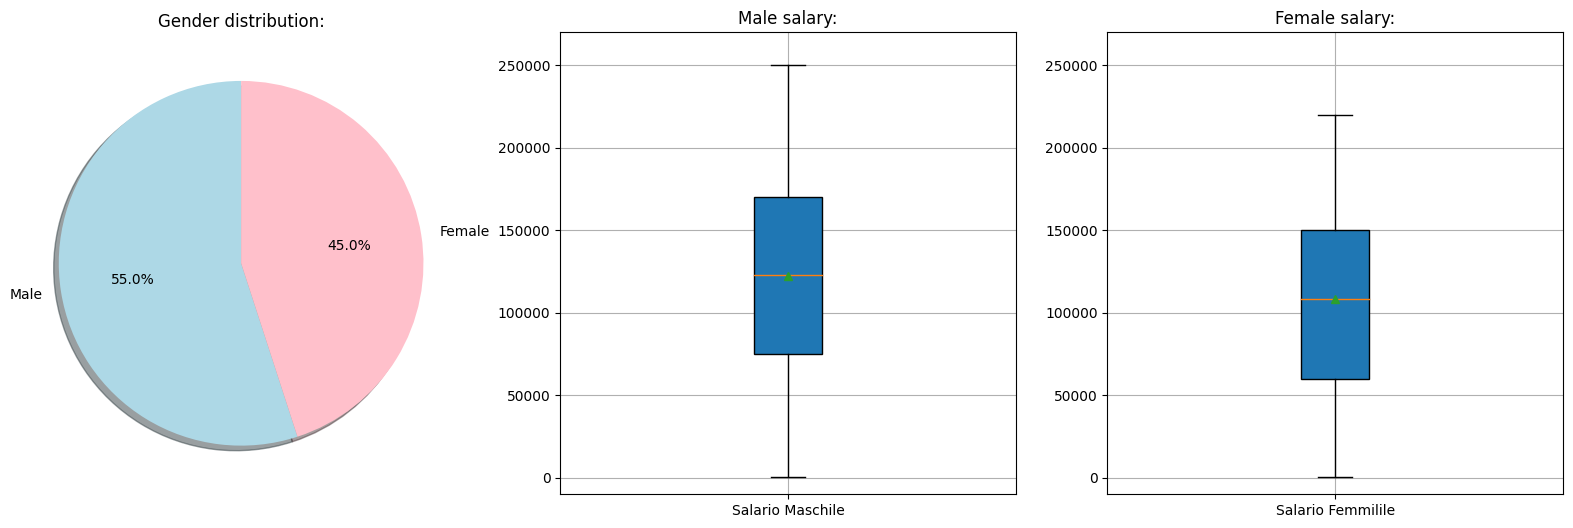

In [19]:
result_counts = dataset['Gender'].value_counts()
gener_colors = {"Male" : "lightblue", "Female" : "pink"}

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1).pie(result_counts, labels = result_counts.index, colors = dataset["Gender"].map(gener_colors), shadow=True, startangle=90, autopct='%1.1f%%')
plt.title('Gender distribution:')


plt.subplot(1, 3, 2).boxplot(dataset[dataset["Gender"] == "Male"]['Salary'] , patch_artist=True, labels=['Salario Maschile'], showmeans=True )
plt.title('Male salary:')
plt.ylim(-10000 , 270000)
plt.grid()
plt.subplot(1, 3, 3).boxplot(dataset[dataset["Gender"] == "Female"]['Salary'], patch_artist=True, labels=['Salario Femmilile'], showmeans=True)
plt.ylim(-10000, 270000)
plt.title('Female salary:')
plt.grid()

As can be seen from the first graph, the population within the dataset is fairly evenly distributed, with a slight disproportion towards the male gender.

The second and third graphs show us the salary distribution. We note that the value of the average female salary is slightly lower than that of the male. 

Let us proceed by analysing in more detail the average salary received by the two genders.

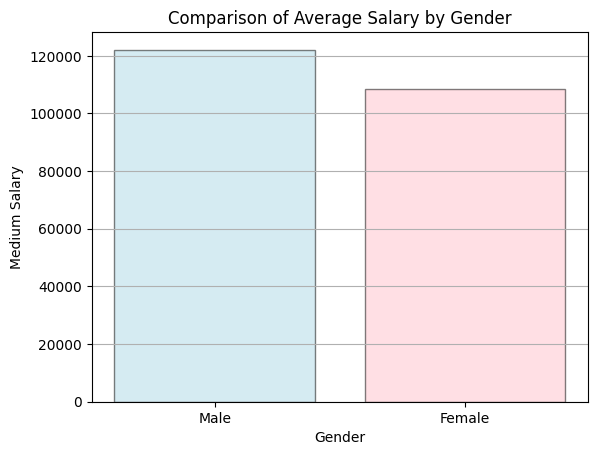

In [20]:
categorie = ['Male', 'Female']
color = ['lightblue', 'pink']
posizione = range(len(categorie))

plt.bar(posizione, [dataset[dataset['Gender'] == 'Male']['Salary'].mean(),
                    dataset[dataset['Gender'] == 'Female']['Salary'].mean()],
                    align='center', alpha=0.5, color=color, edgecolor='black')

plt.xticks(posizione, categorie)
plt.grid(axis='y')
plt.xlabel('Gender')
plt.ylabel('Medium Salary')
plt.title('Comparison of Average Salary by Gender')
plt.show()

The graph shows that there is a difference between the average male and female salary. 

### Relazione tra stipendio e anni di esperienza

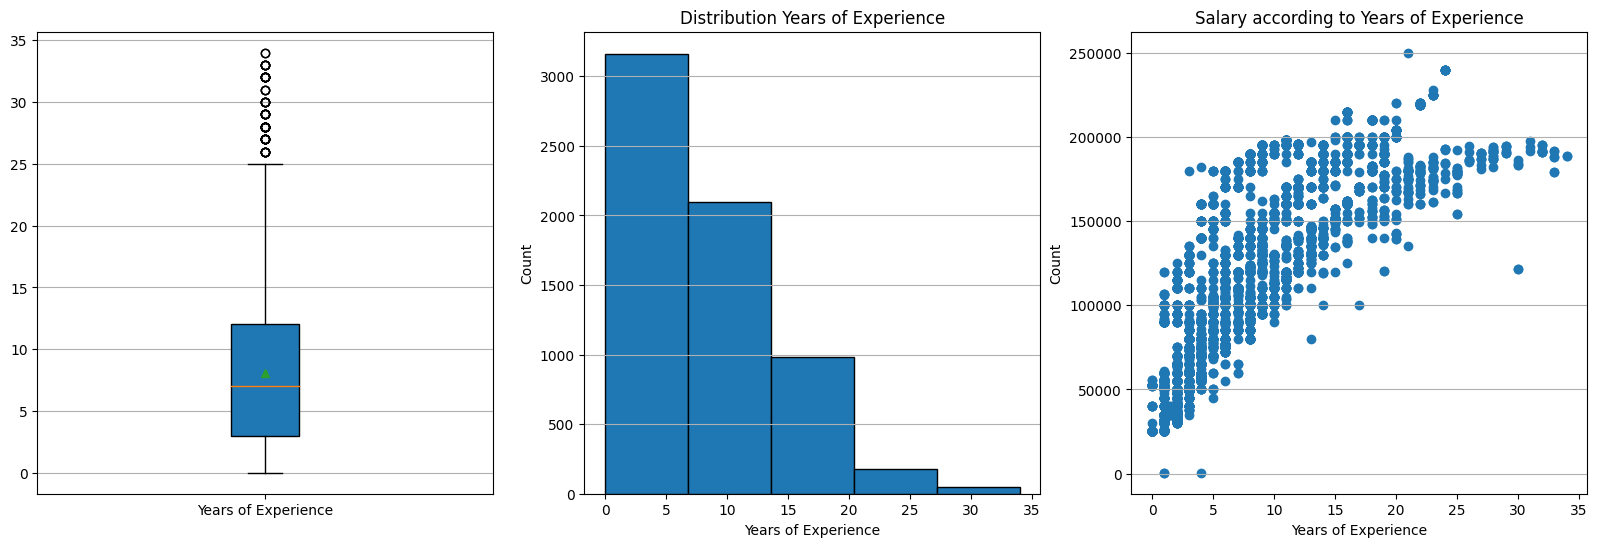

In [21]:
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1).boxplot(dataset['Years of Experience'], showmeans=True, patch_artist=True, labels=['Years of Experience'])
grid = plt.grid(axis='y')

plt.subplot(1,3,2).hist(dataset['Years of Experience'], bins=5, edgecolor='black')
plt.title('Distribution Years of Experience')
plt.xlabel('Years of Experience')
plt.grid(axis='y')
plt.ylabel('Count')

plt.subplot(1,3,3).scatter(dataset['Years of Experience'], dataset["Salary"])
plt.title('Salary according to Years of Experience')
plt.xlabel('Years of Experience')
plt.grid(axis='y')
plt.ylabel('Count')
plt.show()

From the first two graphs we can see that most of the sample of workers analysed have less than 15 years of experience. From the third graph, we can see that the salary increases regularly with years of experience.



### Relationship between age and salary

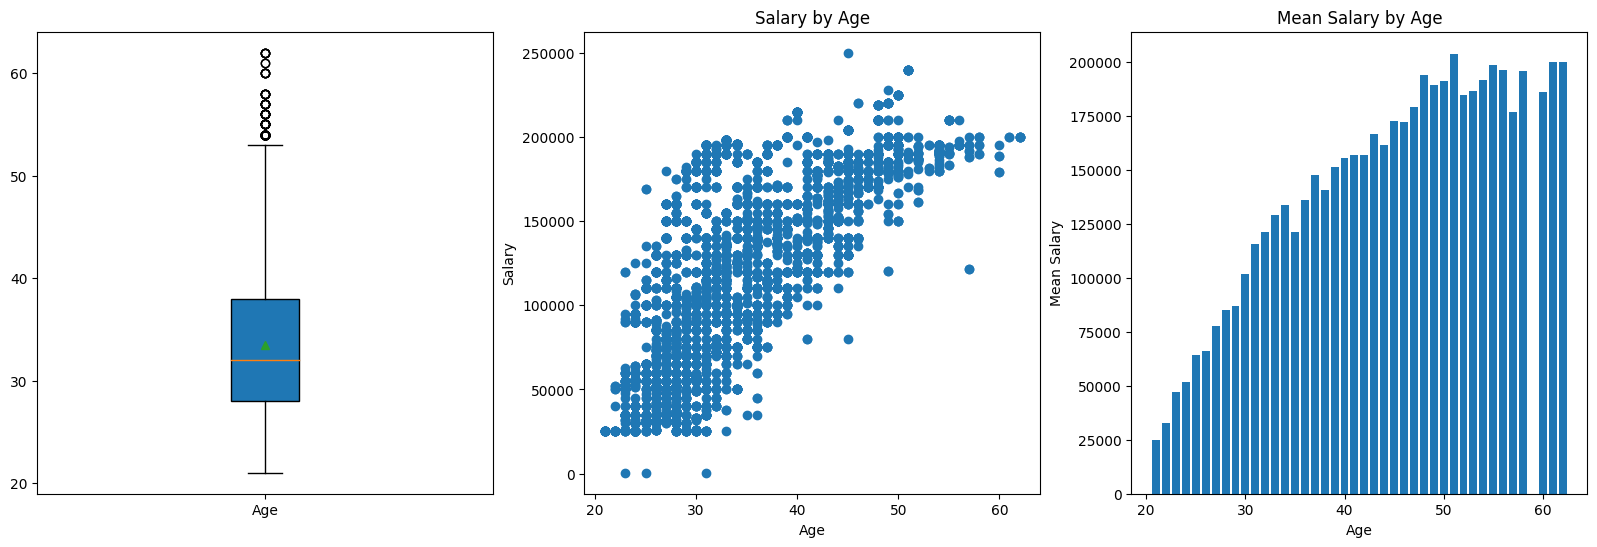

In [22]:
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1).boxplot(dataset['Age'], showmeans=True, patch_artist=True, labels=['Age'])

plt.subplot(1,3,2).scatter(dataset["Age"], dataset["Salary"])
plt.xlabel('Age')
plt.ylabel('Salary')
plt.title('Salary by Age')

age_salary_mean = dataset.groupby('Age')['Salary'].mean()
plt.subplot(1,3,3).bar(age_salary_mean.index, age_salary_mean.values)
plt.xlabel('Age')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Age')
plt.show()

From the first graph, we can see that most of the workers in the sample analysed were under 40 years of age. 

The second and third graphs, on the other hand, indicate a very close relationship between age and salary. Generally, as the former increases, there is an increase in the latter.

### Relationship between education level and salary

Let's study how an employee's level of education can affect his or her salary

Text(0, 0.5, 'Salary')

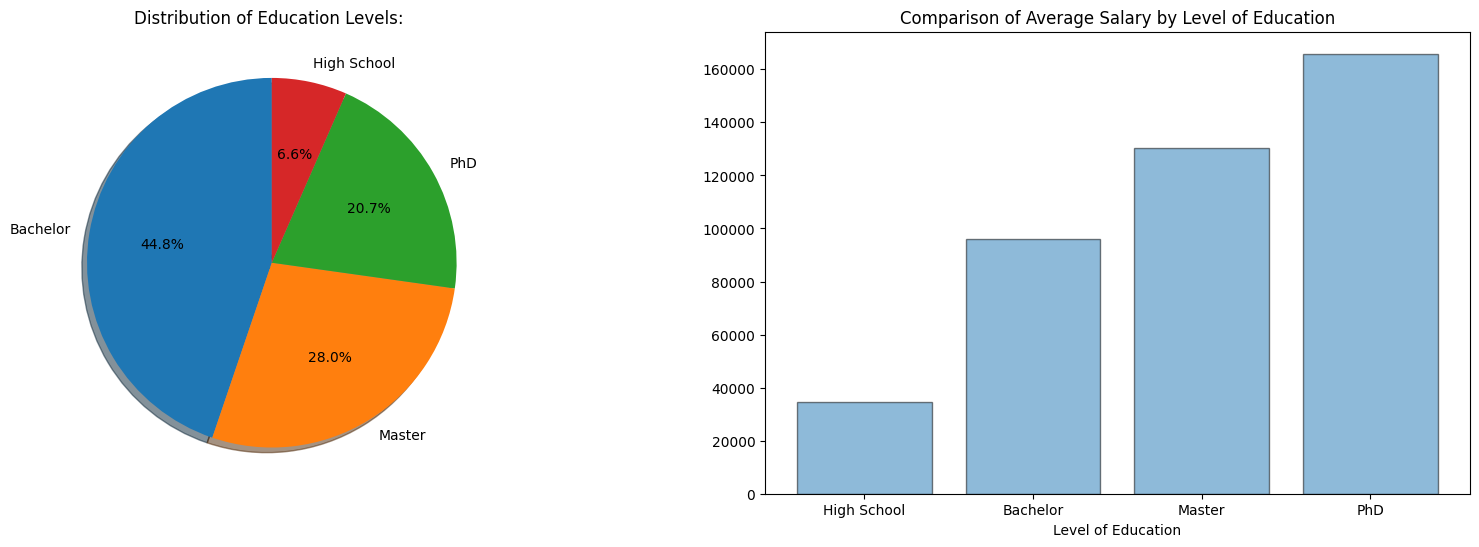

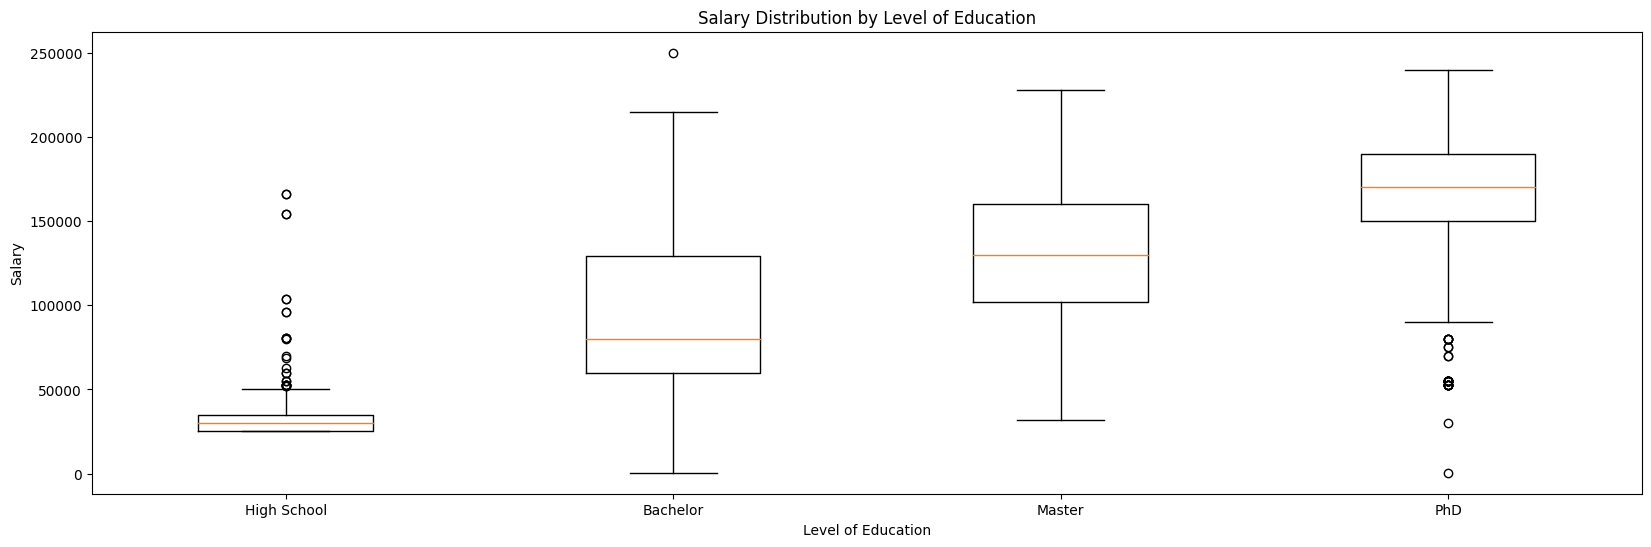

In [23]:
mean_salary_by_ed = [dataset[dataset['Education Level'] == 'High School']['Salary'].mean(),
                    dataset[dataset['Education Level'] == 'Bachelor']['Salary'].mean(), 
                    dataset[dataset['Education Level'] == 'Master']['Salary'].mean(),
                    dataset[dataset['Education Level'] == 'PhD']['Salary'].mean()]
categorie = [ 'High School', 'Bachelor', 'Master', 'PhD']
posizione = range(len(categorie))


plt.figure(figsize=(20, 6))

plt.subplot(1,2,1).pie(dataset["Education Level"].value_counts(),labels = dataset["Education Level"].value_counts().index , shadow=True, startangle=90, autopct='%1.1f%%')
plt.title('Distribution of Education Levels: ')

plt.subplot(1,2,2).bar(posizione, mean_salary_by_ed, align='center', alpha=0.5, edgecolor='black')
plt.xticks(posizione, categorie)
plt.xlabel('Level of Education')
plt.title('Comparison of Average Salary by Level of Education')

plt.figure(figsize=(20, 6))
plt.boxplot([dataset[dataset["Education Level"] == "High School"]['Salary'],
            dataset[dataset["Education Level"] == "Bachelor"]['Salary'],
            dataset[dataset["Education Level"] == "Master"]['Salary'],
            dataset[dataset["Education Level"] == "PhD"]['Salary']])
plt.xticks(range(1, len(categorie) + 1), categorie)
plt.title('Salary Distribution by Level of Education')
plt.xlabel('Level of Education')
plt.ylabel('Salary')

Although the classes are unbalanced and there are some outliers, an increase in the stipendo as a function of qualification is evident. \
One possible explanation for this phenomenon could be that a higher degree of education gives access to better paid jobs. 

### Relationship between job position and salary

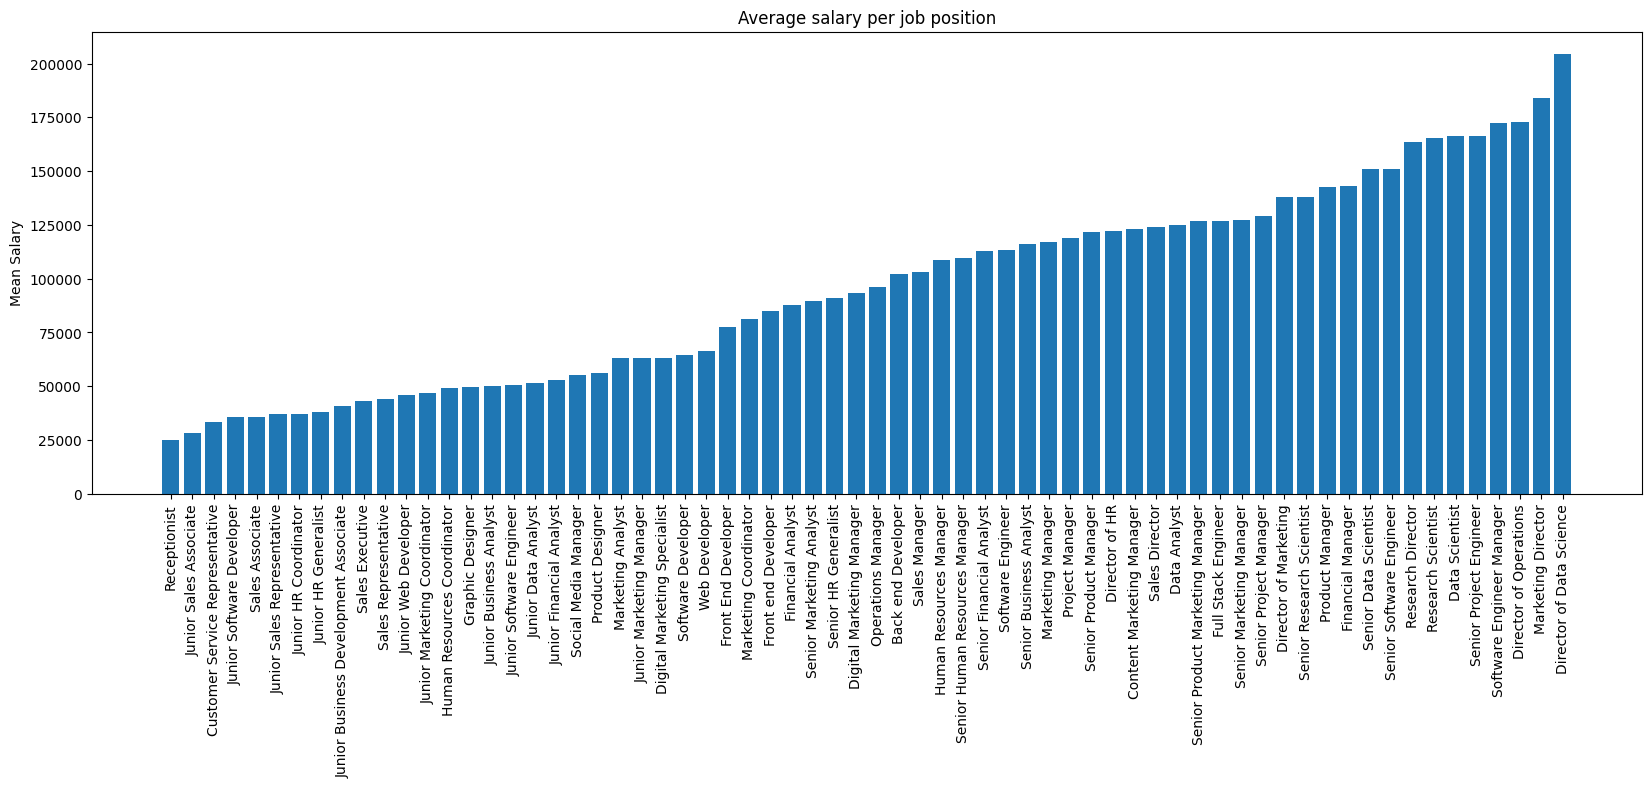

In [24]:
mean_salary_by_job = dataset.groupby('Job Title')['Salary'].mean()
mean_salary_by_job = mean_salary_by_job.sort_values(ascending=True)

plt.figure(figsize=(20, 6))  
plt.bar(mean_salary_by_job.index, mean_salary_by_job.values)  
plt.ylabel('Mean Salary')  
plt.title('Average salary per job position')  
plt.xticks(rotation=90) 
plt.show()  

The graph shows how the average salary of an employee is closely linked to the work performed.

### Results of the exploratory survey

The analysis showed that the salary is related to the factors
- Age
- Gender
- Job position
- Years of experience
- Title of study 

Using these five features, we would build forecasting models.

## Part 3: Model training and analysis

Let us now train prediction models using the data described above. \
We will first test several recursion methods, and then focus on the one that returns the best results.  
The models we are going to test will be: 
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net Regression
- Decision Tree Regression
- XGBoost Regressor

We then go on to define a function that will allow us to assess the accuracy of each model.

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))


def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

We proceed by dividing the dataset into 2 parts, used to train and validate the models.

In [26]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

x_train = train_set.drop(columns=["Salary"])
y_train = train_set["Salary"]
x_test = test_set.drop(columns=["Salary"])
y_test = test_set["Salary"]

Within the dataset there are some categorical columns, and the numerical data are not standardised. By means of the `preprocessor`, we can carry out differentiated preprocessing by column type.

In [27]:
#librerie necessarie 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [28]:
categorical_vars = ['Gender', 'Education Level', 'Job Title']
numeric_vars = ['Age', 'Years of Experience']


In [29]:
preprocessor = ColumnTransformer([
    # name           filter            columns
    ( "numeric"    , StandardScaler(), numeric_vars),
    ( "categorical", OneHotEncoder() , categorical_vars)
])

#### Linear Regression
Let us create a pipeline for training a model obtained by linear regression,

We begin by testing linear recursion of degree 1.

In [30]:
#import necessari
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [31]:
lin_reg = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

lin_reg.fit(x_train, y_train)
print_eval(x_train, y_train, lin_reg)


   Mean squared error: 4.5642e+08
       Relative error: 19.77186%
R-squared coefficient: 0.8378


We get a good result straight away. The model looks promising, let us try running a gridsearch in order to find the best hyperparameters.

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [33]:
lin_reg_gs = Pipeline([
    ("preproc", ColumnTransformer([
        ('poly', PolynomialFeatures(include_bias=False), numeric_vars),
        ( "numeric"    , StandardScaler(), numeric_vars),
        ( "categorical", OneHotEncoder() , categorical_vars)
    ])),
    ("regr", LinearRegression())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__poly__degree": np.linspace(1, 5, 5).astype(int),
    "preproc__categorical__drop": [None, "first"]
}

#include
gs_linreg = GridSearchCV(lin_reg_gs, grid)
gs_linreg.fit(x_train, y_train)    

GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('poly',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('categorical',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'Education '
                                                                          'Level',
                                                                          'Job '
                                                                          'Title'])])),
                                       ('regr', LinearRegression())]),
             param_grid={'preproc__categorical__drop': [None, 'first'],
                         'preproc__numeric': ['passthrough', StandardScaler()],
                         'preproc__poly__degree': array([1, 2, 3, 4, 5])})

In [34]:
print("Error calculated on the training set:")
print_eval(x_train, y_train, gs_linreg)
print("\n")
print("Error calculated on the validation set:")
print_eval(x_test, y_test, gs_linreg)

Error calculated on the training set:
   Mean squared error: 3.3052e+08
       Relative error: 17.26819%
R-squared coefficient: 0.88254


Error calculated on the validation set:
   Mean squared error: 3.3393e+08
       Relative error: 22.24310%
R-squared coefficient: 0.87529


Thanks to this process, we are able to achieve a better score than the previous model. \
We then look at the best hyperparameters found by the gridsearch process

In [35]:
gs_linreg.best_params_

{'preproc__categorical__drop': None,
 'preproc__numeric': 'passthrough',
 'preproc__poly__degree': 2}

Let us analyse the coefficients of the trained model

In [36]:
par = np.array(gs_linreg.best_estimator_.named_steps["regr"].coef_)
print(par)
print("\n The coefficient with the smallest absolute value is:", np.abs(par).min())

[ -7638.82932939  13370.64354195    246.20765439   -445.29941278
    -81.20950614  -7638.82932939  13370.64354195    481.85499302
   -481.85499301   1070.35450741  -7886.97277858   1843.09254402
   4973.52572714  12850.09994587  -1293.7092933   -9721.84091221
  37997.97257359  34166.8365087   -9679.89660201  -8796.67772323
  39972.96805754 -14674.22625132  -2539.18630706   1453.59085905
   6194.84709977  16092.97768104   4305.74006446   9983.26709247
  15703.17493895  -5296.77764564 -16102.60941148 -12243.01861009
  -6093.56262072  -6124.73933562 -10215.26947277  -5814.37683036
 -10733.04429432  -8971.53195498  -4713.24180439 -14711.52874587
  -7376.47431813 -11531.67642944 -14108.77249756   5303.59192844
  -9072.79054389  -2983.45525536  -8574.9276352   30559.66043053
  -4785.5349552  -11555.56616223  -1722.65083298  32753.91051333
   3039.08755452  -1116.01933771  17691.17967548  18364.43282958
  -3616.08723703   2627.50335666  -6707.55869757   1599.77706786
 -15463.74470048 -10043.4

The coefficients take on very high absolute values. This can cause an irregular pattern in the model and consequently errors. 

Let us try to increase the score of the model by applying some regularisation techniques.

#### Ridge Regression

In [37]:
#needed imports
from sklearn.linear_model import Ridge

Let us try to train a simple model via Ridge Regression

In [38]:
ridge_reg = Pipeline([
    ("preproc", ColumnTransformer([
        ( "numeric"    , StandardScaler(), numeric_vars),
        ( "categorical", OneHotEncoder() , categorical_vars)
    ])),
    ("regr", Ridge())
])

test_ridge = ridge_reg.fit(x_train, y_train)
print(print_eval(x_train, y_train, test_ridge))

   Mean squared error: 4.5668e+08
       Relative error: 19.78262%
R-squared coefficient: 0.83771
None


Let's check the coefficients: 

In [39]:
par = np.array(test_ridge.named_steps["regr"].coef_)
par.size
print(par)

print("\n The coefficient with the smallest absolute value is:", np.abs(par).min())

[  3042.37399358  29668.95295846   -316.49299736    316.49299765
    916.66993846 -17140.42027396   6965.92621277   9257.82412177
  11666.09642911   2892.93018148 -16395.01961725  40783.04895247
  42147.2243072   -3365.46701064 -12419.45883801  46723.65347819
  -5850.85030436   9516.46157206  -2688.70238817   1709.04620489
  30231.76435589    378.2387332    4139.21727591  17841.1100762
 -16461.29146418 -27272.86664164  -4698.17075603 -21259.6948545
 -23657.81171906 -19459.03283631 -17682.09348944 -20856.5696551
 -20346.09025126 -21651.00173233 -18116.0644321  -18055.62964461
 -18147.15423406 -28843.45541251 -12959.73711594 -21594.88479251
 -10761.62879847  -8489.4650618   48347.10420964   3929.12536685
  -4530.68714106 -13520.80227113  40189.41791522  15595.78124309
 -13050.0397604   38189.29691492  37154.68757332 -12146.40945638
  15752.96495734 -13119.07216733   9153.97414635 -22265.11346649
  -2101.76591545  26556.29427053  -2275.39743947 -15511.78443611
  -8508.93725342 -15586.6569

Still resulting in very large absolute value numbers, we proceed to perform a gridsearch operation to find the best hyperparameters.

In [40]:
ridge_reg = Pipeline([
    ("preproc", ColumnTransformer([
        ('poly', PolynomialFeatures(include_bias=False), numeric_vars),
        ( "numeric"    , StandardScaler(), numeric_vars),
        ( "categorical", OneHotEncoder() , categorical_vars)
    ])),
    ("regr", Ridge())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__poly__degree": np.linspace(5, 8, 4).astype(int),
    "preproc__categorical__drop": [None, "first"], 
    "regr__alpha": 10**np.linspace(-15, 9, 25)
}

gs_ridge = GridSearchCV(ridge_reg, grid)
gs_ridge.fit(x_train, y_train)    

GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('poly',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('categorical',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'Education '
                                                                          'Level',
                                                                          'Job '
                                                                          'Title'])])),
                                       ('regr', Ridge())]),
             param_grid={'preproc__categorical__drop': [None, 'first'],
                         'preproc__numeric': ['passthrough', StandardScaler()],
                         'preproc__poly__degree': array([5, 6, 7, 8]),
                         'regr__alpha': array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
       1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09])})

In [41]:
print("Error calculated on the training set:")
print_eval(x_train, y_train, gs_ridge)
print("\n")
print("Error calculated on the validation set:")
print_eval(x_test, y_test, gs_ridge)

Error calculated on the training set:
   Mean squared error: 3.0585e+08
       Relative error: 16.98381%
R-squared coefficient: 0.89131


Error calculated on the validation set:
   Mean squared error: 3.1992e+08
       Relative error: 23.05708%
R-squared coefficient: 0.88052


Using the hyperparameters found using gridsearch, we manage to obtain a much better score than the previous attempt.

Using Ridge Recursion we obtain a slightly better score than that found using the Linear Recursion method. \
We proceed to display the best parameters found 

In [42]:
gs_ridge.best_params_

{'preproc__categorical__drop': 'first',
 'preproc__numeric': StandardScaler(),
 'preproc__poly__degree': 7,
 'regr__alpha': 1e-09}

After gridsearch operations, we can see that the absolute value of the model co-efficients has reduced considerably.

In [43]:
par = np.array(gs_ridge.best_estimator_.named_steps["regr"].coef_)
print("\n The coefficient with the smallest absolute value is:", np.abs(par).min())


 The coefficient with the smallest absolute value is: 0.021649392820768387


#### Lasso Regression

Ridge regression reduces but does not reset parameter values, so the solution uses all variables, even the irrelevant ones. \
To overcome this problem, we try using Lasso regression.

In [44]:
#import lasso
from sklearn.linear_model import Lasso

In [45]:
lasso_reg = Pipeline([
    ("preproc", ColumnTransformer([
        ('poly', PolynomialFeatures(include_bias=False), numeric_vars),
        ( "numeric"    , StandardScaler(), numeric_vars),
        ( "categorical", OneHotEncoder() , categorical_vars)
    ])),
    ("regr", Lasso())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__poly__degree": np.linspace(5, 8, 4).astype(int),
    "preproc__categorical__drop": [None, "first"], 
    "regr__alpha": 10**np.linspace(-15, 9, 10)
}

gs_lasso = GridSearchCV(lasso_reg, grid)
gs_lasso.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('poly',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('categorical',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'Education '
                                                                          'Level',
                                                                          'Job '
                                                                          'Title'])])),
                                       ('regr', Lasso())]),
             param_grid={'preproc__categorical__drop': [None, 'first'],
                         'preproc__numeric': ['passthrough', StandardScaler()],
                         'preproc__poly__degree': array([5, 6, 7, 8]),
                         'regr__alpha': array([1.00000000e-15, 4.64158883e-13, 2.15443469e-10, 1.00000000e-07,
       4.64158883e-05, 2.15443469e-02, 1.00000000e+01, 4.64158883e+03,
       2.15443469e+06, 1.00000000e+09])})

In [46]:
print("Error calculated on the training set:")
print_eval(x_train, y_train, gs_lasso)
print("\n")
print("Error calculated on the validation set:")
print_eval(x_test, y_test, gs_lasso)

Error calculated on the training set:
   Mean squared error: 3.2002e+08
       Relative error: 17.32859%
R-squared coefficient: 0.88628


Error calculated on the validation set:
   Mean squared error: 3.2546e+08
       Relative error: 22.79511%
R-squared coefficient: 0.87845


The score obtained by the model does not deviate from the results previously obtained. Let us proceed by analysing the best hyperparameters found by gridscearch.

In [47]:
print("Miglior modello:")
gs_lasso.best_params_

Miglior modello:


{'preproc__categorical__drop': None,
 'preproc__numeric': 'passthrough',
 'preproc__poly__degree': 8,
 'regr__alpha': 0.021544346900318777}

In addition, we can see how model coefficients deemed unnecessary are cancelled out.  

In [48]:
par = np.array(gs_lasso.best_estimator_.named_steps["regr"].coef_)
print("\n The coefficient with the smallest absolute value is: ", np.abs(par).min())


 The coefficient with the smallest absolute value is:  0.0


#### Elastic Net Regression

In [49]:
from sklearn.linear_model import ElasticNet

In [50]:
elasticnet_reg = Pipeline([
    ("preproc", ColumnTransformer([
        ('poly', PolynomialFeatures(include_bias=False), numeric_vars),
        ( "numeric"    , StandardScaler(), numeric_vars),
        ( "categorical", OneHotEncoder() , categorical_vars)
    ])),
    ("regr", ElasticNet())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__poly__degree": np.linspace(5, 8, 4).astype(int),
    "preproc__categorical__drop": [None, "first"], 
    "regr__alpha": np.linspace(0, 1, 3),
    "regr__l1_ratio": np.linspace(0, 1, 3)
}

gs_elasticnet = GridSearchCV(elasticnet_reg, grid)
gs_elasticnet.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('poly',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('categorical',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'Education '
                                                                          'Level',
                                                                          'Job '
                                                                          'Title'])])),
                                       ('regr', ElasticNet())]),
             param_grid={'preproc__categorical__drop': [None, 'first'],
                         'preproc__numeric': ['passthrough', StandardScaler()],
                         'preproc__poly__degree': array([5, 6, 7, 8]),
                         'regr__alpha': array([0. , 0.5, 1. ]),
                         'regr__l1_ratio': array([0. , 0.5, 1. ])})

In [51]:
print("Error calculated on the training set:")
print_eval(x_train, y_train, gs_elasticnet)
print("\n")
print("Error calculated on the validation set:")
print_eval(x_test, y_test, gs_elasticnet)

Error calculated on the training set:
   Mean squared error: 3.2003e+08
       Relative error: 17.34039%
R-squared coefficient: 0.88627


Error calculated on the validation set:
   Mean squared error: 3.2565e+08
       Relative error: 22.84829%
R-squared coefficient: 0.87838


In [52]:
print("Best model:")
gs_elasticnet.best_params_

Best model:


{'preproc__categorical__drop': None,
 'preproc__numeric': 'passthrough',
 'preproc__poly__degree': 8,
 'regr__alpha': 1.0,
 'regr__l1_ratio': 1.0}

All the regression methods tested arrive at a similar level of accuracy. 

Let us therefore try a change of method, using regression methods based on Decision Trees. 

#### Decision Tree Regression


In [53]:
from sklearn.tree import DecisionTreeRegressor 

In [54]:
decisiontree_reg = Pipeline([
    ("preproc", ColumnTransformer([
        ( "numeric"    , StandardScaler(), numeric_vars),
        ( "categorical", OneHotEncoder() , categorical_vars)
    ])),
    ("regr", DecisionTreeRegressor(random_state=42))
])

grid = {
    "preproc__categorical__drop": [None, "first"], 
    "regr__max_depth": np.linspace(0, 30, 30).astype(int),
}

gs_dectree = GridSearchCV(decisiontree_reg, grid)
gs_dectree.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('categorical',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'Education '
                                                                          'Level',
                                                                          'Job '
                                                                          'Title'])])),
                                       ('regr',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'preproc__categorical__drop': [None, 'first'],
                         'regr__max_depth': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30])})

In [55]:
print("Error calculated on the training set:")
print_eval(x_train, y_train, gs_dectree)
print("\n")
print("Error calculated on the set:")
print_eval(x_test, y_test, gs_dectree)

Error calculated on the training set:
   Mean squared error: 1.9966e+07
       Relative error: 5.54710%
R-squared coefficient: 0.9929


Error calculated on the set:
   Mean squared error: 6.5937e+07
       Relative error: 10.16921%
R-squared coefficient: 0.97537


We immediately notice that by using Decision Tree Regression, the prediction result appears much more accurate than linear regression. It was possible to arrive at a very accurate model, with R^2 scores much higher than 0.9, on both the training set and the validation set. we proceed by displaying the best hyperparameters.

In [56]:
gs_dectree.best_params_

{'preproc__categorical__drop': None, 'regr__max_depth': 25}

### XGBoost Regressor

In [57]:
from xgboost import XGBRegressor

In [58]:
xgboost_reg = Pipeline([
    ("preproc", ColumnTransformer([
        ( "numeric"    , StandardScaler(), numeric_vars),
        ( "categorical", OneHotEncoder() , categorical_vars)
    ])),
    ("regr", XGBRegressor(objective='reg:squarederror', reg_alpha=0.0,
    reg_lambda=1.0, n_estimators=200))
], verbose=True)


xgboost_reg.fit(x_train, y_train)

[Pipeline] ........... (step 1 of 2) Processing preproc, total=   0.0s
[Pipeline] .............. (step 2 of 2) Processing regr, total=   0.3s


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Education Level',
                                                   'Job Title'])])),
                ('regr',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              e...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))],
         verbose=True)

In [59]:
print("Error calculated on the training set:")
print_eval(x_train, y_train, xgboost_reg)
print("\n")
print("Error calculated on the validation set:")
print_eval(x_test, y_test, xgboost_reg)

Error calculated on the training set:
   Mean squared error: 2.5231e+07
       Relative error: 6.59519%
R-squared coefficient: 0.99103


Error calculated on the validation set:
   Mean squared error: 5.2033e+07
       Relative error: 11.12336%
R-squared coefficient: 0.98057


The results are very similar to those obtained by Decision Tree Regression. 

### Using the best model
We proceed to train the final model. Given the excellent results obtained by the model based on Decision Tree Regression, we proceed to train it using this method. 
To do this, we will apply this regression method, using the cross validation method for training, in order to obtain a more accurate estimate of the final performance.

In [60]:
from sklearn.model_selection import KFold

In [61]:
kf = KFold(5, shuffle=True, random_state=42)
gs_dectree_kf = GridSearchCV(decisiontree_reg, grid, cv=kf)
gs_dectree_kf.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Years '
                                                                          'of '
                                                                          'Experience']),
                                                                        ('categorical',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'Education '
                                                                          'Level',
                                                                          'Job '
                                                                          'Title'])])),
                                       ('regr',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'preproc__categorical__drop': [None, 'first'],
                         'regr__max_depth': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30])})

In [62]:
print("Error calculated on the training set:")
print_eval(x_train, y_train, gs_dectree_kf)
print("\n")
print("Error calculated on the validation set:")
print_eval(x_test, y_test, gs_dectree_kf)

Error calculated on the training set:
   Mean squared error: 2.014e+07
       Relative error: 5.63099%
R-squared coefficient: 0.99284


Error calculated on the validation set:
   Mean squared error: 6.7506e+07
       Relative error: 10.30325%
R-squared coefficient: 0.97479


We can now use the model to predict a worker's salary. We can do this using the `predict()` function provided by sklearn. \
Some examples are given below.

In [63]:
dummy_empl = pd.DataFrame({
    "Age": [30],
    "Gender": ["Male"],
    "Education Level": ["Bachelor"],
    "Job Title": ["Software Engineer"],
    "Years of Experience": [5]
})

gs_dectree_kf.predict(dummy_empl)

array([75000.])

In [64]:
dummy_empl = pd.DataFrame({
    "Age": [40],
    "Gender": ["Female"],
    "Education Level": ["Master"],
    "Job Title": ["Data Scientist"],
    "Years of Experience": [15]
})
gs_dectree_kf.predict(dummy_empl)

array([134641.])